In [1]:
import os 
import sys
sys.path.append("..")
os.chdir("..")

In [45]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import seaborn as sns  
import matplotlib.pyplot as plt
import duckdb
import numpy as np

transaction_df = pd.read_csv("data/dh_transactions.csv")
product_df = pd.read_csv("data/dh_product_lookup.csv")
causal_df = pd.read_csv("data/dh_causal_lookup.csv")
store_df = pd.read_csv("data/dh_store_lookup.csv")

In [5]:
# Add more columns
product_df["product_name"] = product_df["product_description"] + " " + product_df["product_size"]

In [6]:
# We will use this df often to map from upc to product_name
map_product_df = duckdb.query("""
    SELECT transaction_df.upc, product_df.product_name
    FROM transaction_df
    INNER JOIN product_df
    ON transaction_df.upc = product_df.upc
""").df()

## About This Notebook

- Our goal is to predict next week's dollar sale for specific products. Undoubtly, we choose the top sale product called PRIVATE LABEL THIN SPAGHETTI 16 OZ. In latter, AJ BUTTERMILK PANCAKE MIX 32 Oz (other than pasta commodity) 

In [12]:
from typing import List, Union

# Randomize two of products
selected_product : List[str] = ["PRIVATE LABEL THIN SPAGHETTI 16 OZ",
                               "AJ BUTTERMILK PANCAKE MIX 32 OZ"]

In [9]:
spaghet_upc : int = map_product_df.query(f"product_name == '{selected_product[0]}'").upc.unique()[0]
butmilk_upc : int = map_product_df.query(f"product_name == '{selected_product[1]}'").upc.unique()[0]

In [17]:
def get_day_series(upc:int,store_id:Union[int,None]=None)->pd.Series:
    global transaction_df
    
    product_transaction_df = transaction_df.query(f"upc == {upc}")
    
    # Filter the transaction if store_id is not None
    store_ts_df = product_transaction_df.query(f"store == {store_id}") if store_id else product_transaction_df
    day_series = store_ts_df.groupby("day").aggregate(dollar_sales=("dollar_sales","sum"))
    return day_series

### Scale the application
- Since predicting next week's sale does not require real-time. Mostly, we prefer the accuracy of them. This indicate that the selected model can be complex, heavyweight. with tradeoff of high accuracy. However, interpretability is much more preferred if it's accurate. (This could be the simple model like mean model, stationary time series model)

- Recall that our purpose is to predict the next week's sale forecast. We need to define how can we evaluate the accuracy of the model. After doing some researchs, we found out that RMSE is appropriate. Here's a evaluation function which return RMSE  

In [51]:
def evaluate(truths:np.ndarray,preds:np.ndarray)->float:
    rmse = np.sqrt(np.power(truths - preds,2)).mean(axis=0)
    return rmse

### Private label thin spaghetti Forecast
- Our goal is to predict the next's week dollar sales
- After a lot of trial and error, we found out that using time series where timestep is day is more reliable than aggregated week. The possible reasons might be due to amount of data (amount of day > week), and weekly seasonality  

In [22]:
current_product_name : str = selected_product[0]

In [31]:
s = get_day_series(spaghet_upc)

# First differencing series (d = y_t - y_t1)
s_d1 = s.diff().dropna()

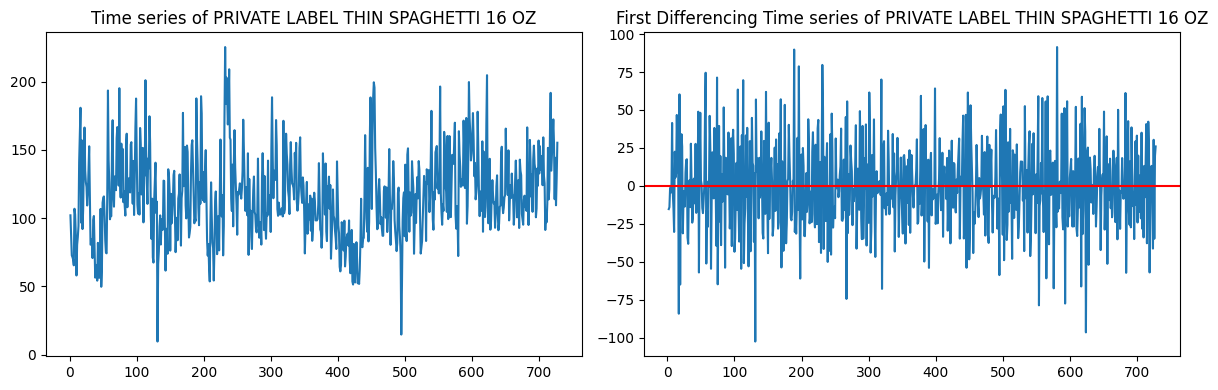

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Create a figure with 1 row and 2 columns for subplots
# Plot autocorrelation
axes[0].plot(s)  
axes[0].set_title(f"Time series of {current_product_name}")

# Plot partial autocorrelation
axes[1].plot(s_d1)  
axes[1].axhline(y=s_d1.mean().values, color='r', linestyle='-')
axes[1].set_title(f"First Differencing Time series of {current_product_name}")

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# plot_acf_pacf(s1_d1,lags=50,series_name="s1_d1")

- First Differencing Time Series is very likely to be stationary which mean is around zero. This type of time series is very appropriate with simple, interpretability model. We select this time series to be analyzed further

- This indicates that the change over time is constant around zero mean, with our naked eye, variance seems to be constant. However, we will validate later

- Let's inspecting this 1st order time series 

#### Is 1st order time series stationary?
- Stationary means the value does not change over timestep. If it is stationary. There are a lot of model we can use here like ARIMA

In [32]:
from statsmodels.tsa.stattools import adfuller

def test_stationary(s:np.ndarray, p_value_thresh = 0.05)->None:
    result = adfuller(s)

    print(f'ADF Statistic: {result[0] : .2f}')
    print(f'P-Value: {result[1] : .2f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if result[1] < p_value_thresh:
        print("We conclude that this time series is stationary")

In [33]:
test_stationary(s_d1)

ADF Statistic: -8.88
P-Value:  0.00
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
We conclude that this time series is stationary


#### What does ACF and PACF plot of 1st order time series looks like?
- These plots informs us the autocorrelation between its value (y_t) and its previous lagged value (y_(t-n))
- Also, it can inform seasonality

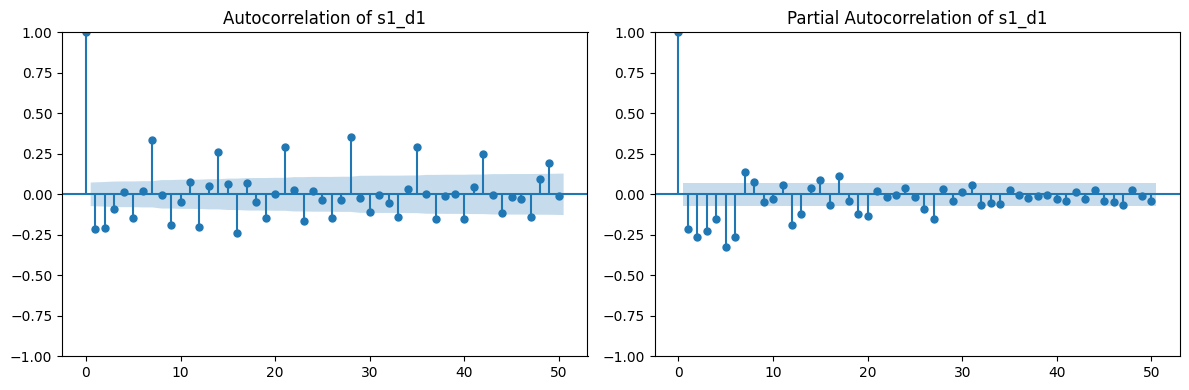

In [35]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(s,lags:int,series_name:str):
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Create a figure with 1 row and 2 columns for subplots
    # Plot autocorrelation
    plot_acf(s, lags=lags, ax=axes[0])  # Plot in the first subplot
    axes[0].set_title(f"Autocorrelation of {series_name}")

    # Plot partial autocorrelation
    plot_pacf(s, lags=lags, ax=axes[1])  # Plot in the second subplot
    axes[1].set_title(f"Partial Autocorrelation of {series_name}")

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()
    
plot_acf_pacf(s_d1,lags=50,series_name="s1_d1")

- Clearly, we can see that there is a seasonality over weeks (7th, 14th, 7n lagged value). This indicate that day like Sunday, Monday,.. Saturday often has their own characteristic.
- For Differencing series (D1). With Partial Autocorrelation shape, it is roughly exponential decay. Furthermore, Autocorrelation is also exponential decay, and comes with seasonal. This indicates that models like SARIMA which take seasonality into an account may be appropriate. Since our first order time series is already stationary.
- Assume that the variance of time series is zero over time.


- Let's fit our proposed model : SARIMA with D=1 and m=7 (D as order differencing, and m as Seasonality)
- Since our goal to find the best model which is most accurate in predicting the next week's sale. We proposed the test set as last 7 day.

In [41]:
# Split train/test 
test_size = 7
train_s = s[:-test_size]
test_s = s[-test_size:]

#### Baseline model
- It's better to start from the simpliest model like mean model. The simple model have better performance. 

In [132]:
# From mean model
# predicted_value = train_s.dollar_sales.mean()
test_pred = (test_s.dollar_sales - predicted_value).sum()\

# Next week sales 
test_pred *= 7

In [141]:
# Next week sales 
test_pred *= 7

In [147]:
test_truth = test_s.dollar_sales.to_numpy().sum()
score = evaluate(np.array([test_pred]),
                 np.array([test_truth]))

# # Save score from mean_model
score_dict = {"mean_model" : score}

- Recall that SARIMA is the time series which has hyperparameters as the following
    - ARIMA(p,d=1,q)(P,D,Q)[m=7]
- Statistically, we never what is the best hyperparameters for them. In my case, We only know d and m (Although not necessary best, but let's fix due to limited amount of time)

In [42]:
from pmdarima import auto_arima

# hyperparameter configuration
hyperparam_dict = dict(d=1,
                       max_p=5,
                       max_q=28,
                       m=7,
                       seasonal=True)

# Fit best model 
best_model = auto_arima(train_s,**hyperparam_dict)
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  719
Model:             SARIMAX(1, 1, 2)x(2, 0, [1], 7)   Log Likelihood               -3245.540
Date:                             Sun, 17 Mar 2024   AIC                           6507.080
Time:                                     21:33:27   BIC                           6543.692
Sample:                                          0   HQIC                          6521.216
                                             - 719                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.002      0.189      0.850      -0.004       0.004
ar.L1          0.7151      0.055     12.915      0.000       0.607       0.824
ma.L1         -1.2313      0.072    -17.033      0.000      -1.373      -1.090
ma.L2          0.2490      0.066      3.755      0.000       0.119       0.379
ar.S.L7        1.0472      0.053     19.591      0.000       0.942       1.152
ar.S.L14      -0.0754      0.047     -1.588      0.112      -0.168       0.018
ma.S.L7       -0.8463      0.037    -22.837      0.000      -0.919      -0.774
sigma2       485.8195     21.818     22.266      0.000     443.056     528.583
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                51.39
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.34
Prob(H) (two-sided):                  0.37   Kurtosis:                         4.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Let's check the result

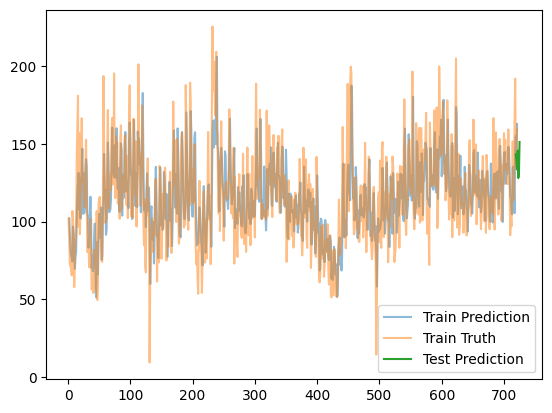

In [48]:
train_pred = best_model.predict_in_sample(start=1)#.to_numpy()
test_pred, test_conf_int = best_model.predict(test_size,return_conf_int=True,alpha=0.05)#.to_numpy()

train_truth = train_s#.to_numpy()
test_truth = test_s#.to_numpy()

# Extracting upper and lower bounds
test_lower_bound = [x[0] for x in test_conf_int]
test_upper_bound = [x[1] for x in test_conf_int]

plt.plot(train_pred,alpha=0.5,label="Train Prediction")
plt.plot(train_truth,alpha=0.5,label="Train Truth")
plt.plot(test_pred,label="Test Prediction")
plt.legend()
plt.show()

Let's predict next's week dollar sales which is in test set

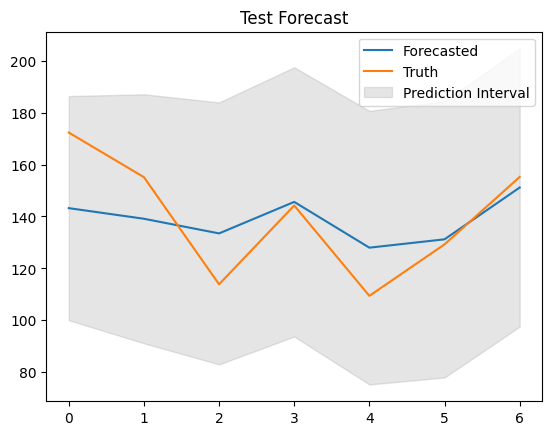

In [49]:
plt.plot(test_pred.to_numpy(),label="Forecasted")
plt.plot(test_truth.to_numpy(),label="Truth")
plt.fill_between(range(len(test_pred)), test_conf_int[:,0], test_conf_int[:,1], color='gray', alpha=0.2, label='Prediction Interval')
plt.legend()
plt.title("Test Forecast")
plt.show()

- Note : Grey Area represents the prediction interval where mean is the forecasted value. We are 95% confident that the predicted value range should be within this gray area

- We can see that truth is actually located in grey area. This indicates the reliability of the model
- Let's evaluate the score of this prediction 

In [59]:
test_pred = test_pred.to_numpy()
test_truth = test_truth.to_numpy().flatten()
score = evaluate(test_pred,test_truth)
print(f"RMSE over 7 days : {score}")

RMSE over 7 days : 12.969856015622296


In [62]:
week_forecast = test_pred.sum()
week_truth = test_truth.sum()

print(f"Next week's forecast : {week_forecast}")
print(f"Next week's Truth : {week_truth}")
print(f"Next week's RMSE Error : {evaluate(np.array([week_truth]),np.array([week_forecast]))}")

Next week's forecast : 971.7393379898353
Next week's Truth : 979.46
Next week's RMSE Error : 7.720662010164688


In [151]:
score_dict[f"sarimax{(1,1,2)}{(2, 0, 1, 7)}"] = evaluate(np.array([week_truth]),np.array([week_forecast]))

In [152]:
# CLearly, sarimax model performs better. Better than guessing by mean
score_dict

{'mean_model': 1253.7369958275376,
 'sarimax(1, 1, 2)(2, 0, 1, 7)': 77.16454574765044}

- In my opinion, even this simple model can accurately forecast the dollar sale. The error with lower than 10 dollar. For now, let's stick to this best parameter model, we are going retrain the model, but the training set for now is the whole series

- Recall that Our best model is SARIMAX(1, 1, 2)x(2, 0, [1], 7)

In [64]:
from pmdarima.arima import ARIMA
final_model = ARIMA(order=(1,1,2),seasonal_order=(2, 0, 1, 7))

# Refit the model
final_model.fit(s)
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  726
Model:             SARIMAX(1, 1, 2)x(2, 0, [1], 7)   Log Likelihood               -3275.809
Date:                             Sun, 17 Mar 2024   AIC                           6567.619
Time:                                     21:48:35   BIC                           6604.308
Sample:                                          0   HQIC                          6581.779
                                             - 726                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.002      0.351      0.725      -0.003       0.004
ar.L1          0.7260      0.054     13.553      0.000       0.621       0.831
ma.L1         -1.2462      0.070    -17.677      0.000      -1.384      -1.108
ma.L2          0.2633      0.065      4.072      0.000       0.137       0.390
ar.S.L7        1.0412      0.052     20.016      0.000       0.939       1.143
ar.S.L14      -0.0688      0.046     -1.487      0.137      -0.160       0.022
ma.S.L7       -0.8456      0.036    -23.492      0.000      -0.916      -0.775
sigma2       479.2516     21.167     22.642      0.000     437.765     520.738
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                52.04
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.34
Prob(H) (two-sided):                  0.36   Kurtosis:                         4.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Hence's our next week's sale is

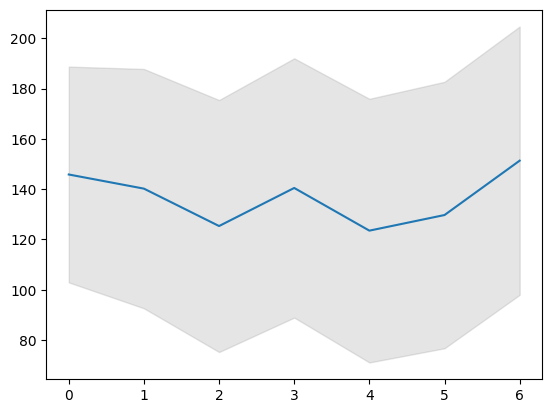

In [70]:
test_pred, test_conf_int = final_model.predict(7,return_conf_int=True,alpha=0.05)
test_pred = test_pred.to_numpy().flatten()
plt.plot(test_pred,label="Predict")
plt.fill_between(range(len(test_pred)), test_conf_int[:,0], test_conf_int[:,1], color='gray', alpha=0.2, label='Prediction Interval')
plt.show()

In [81]:
max_week_forecast = test_conf_int[:,1].sum()

1307.218749274469

In [89]:
mean_week_forecast = test_pred.sum()
min_week_forecast = test_conf_int[:,0].sum()
max_week_forecast = test_conf_int[:,1].sum()

print(f"95% confident : Next week's forecast : {mean_week_forecast:.2f} ± {max_week_forecast-mean_week_forecast:.2f} dollars for {current_product_name}")

95% confident : Next week's forecast : 956.30 ± 350.92 dollars for PRIVATE LABEL THIN SPAGHETTI 16 OZ


### Aj buttermilk pancake mix 32 oz Forecast


In [ ]:
from typing import List, Union

# Randomize two of products
selected_product : List[str] = ["PRIVATE LABEL THIN SPAGHETTI 16 OZ",
                               "AJ BUTTERMILK PANCAKE MIX 32 OZ"]

In [93]:
current_product_name = selected_product[1]

In [103]:
s = get_day_series(butmilk_upc)

# First differencing series (d = y_t - y_t1)
s_d1 = s.diff(1).dropna()

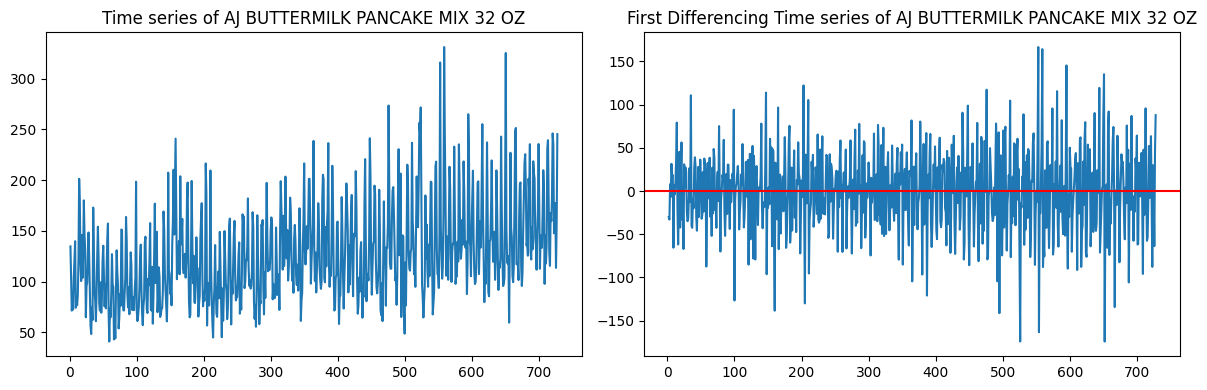

In [104]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Create a figure with 1 row and 2 columns for subplots
# Plot autocorrelation
axes[0].plot(s)  
axes[0].set_title(f"Time series of {current_product_name}")

# Plot partial autocorrelation
axes[1].plot(s_d1)  
axes[1].axhline(y=s_d1.mean().values, color='r', linestyle='-')
axes[1].set_title(f"First Differencing Time series of {current_product_name}")

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

- There is a linear fashion trend over time. It is common to do first oder differencing series (As we did previously)
- You can see that 1st order differencing series mean is constant (around zero)

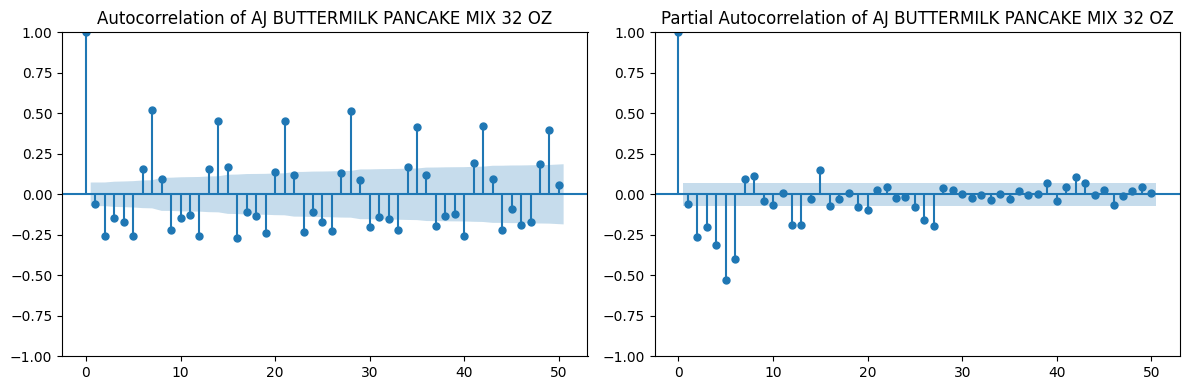

In [96]:
plot_acf_pacf(s_d1,lags=50,series_name=current_product_name)

- Similar to Private Spaghetti. There is a week seasonality. What's obviously different based on Partial Autocorrelation plot is that there is a relatively strong correlation between first lag and fifth lag. We predict that if we use SARIMA, then the best q would be 5. We will check later

In [106]:
# Split train/test 
test_size = 7
train_s = s[:-test_size]
test_s = s[-test_size:]

#### Baseline model

In [155]:
# predicted_value = train_s.dollar_sales.mean()
test_pred = (test_s.dollar_sales - predicted_value).sum()\

# Next week sales 
test_pred *= 7

test_truth = test_s.dollar_sales.to_numpy().sum()
score = evaluate(np.array([test_pred]),
                 np.array([test_truth]))

# # Save score from mean_model
score_dict = {"mean_model" : score}
score_dict

{'mean_model': 1253.7369958275376}

In [107]:
from pmdarima import auto_arima

# hyperparameter configuration
hyperparam_dict = dict(max_d=3,
                       max_p=5,
                       max_q=28,
                       m=7,
                       seasonal=True)

# Fit best model 
best_model = auto_arima(train_s,**hyperparam_dict)
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  719
Model:             SARIMAX(5, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -3454.807
Date:                                Sun, 17 Mar 2024   AIC                           6933.614
Time:                                        22:04:56   BIC                           6988.532
Sample:                                             0   HQIC                          6954.818
                                                - 719                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0023      0.008      0.270      0.787      -0.014       0.019
ar.L1          0.3124      0.030     10.319      0.000       0.253       0.372
ar.L2          0.0594      0.040      1.475      0.140      -0.020       0.138
ar.L3          0.0004      0.038      0.012      0.991      -0.075       0.076
ar.L4         -0.0418      0.040     -1.040      0.298      -0.121       0.037
ar.L5          0.0110      0.035      0.312      0.755      -0.058       0.080
ma.L1         -0.9825      0.011    -85.868      0.000      -1.005      -0.960
ar.S.L7        0.0840      0.300      0.280      0.779      -0.504       0.672
ar.S.L14       0.8684      0.293      2.968      0.003       0.295       1.442
ma.S.L7        0.1143      0.313      0.365      0.715      -0.500       0.728
ma.S.L14      -0.6713      0.249     -2.701      0.007      -1.158      -0.184
sigma2       845.6091     32.389     26.108      0.000     782.127     909.091
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               356.64
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                             0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

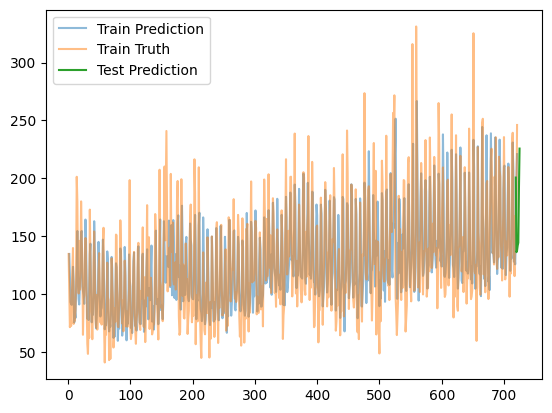

In [108]:
train_pred = best_model.predict_in_sample(start=1)#.to_numpy()
test_pred, test_conf_int = best_model.predict(test_size,return_conf_int=True,alpha=0.05)#.to_numpy()

train_truth = train_s#.to_numpy()
test_truth = test_s#.to_numpy()

# Extracting upper and lower bounds
test_lower_bound = [x[0] for x in test_conf_int]
test_upper_bound = [x[1] for x in test_conf_int]

plt.plot(train_pred,alpha=0.5,label="Train Prediction")
plt.plot(train_truth,alpha=0.5,label="Train Truth")
plt.plot(test_pred,label="Test Prediction")
plt.legend()
plt.show()

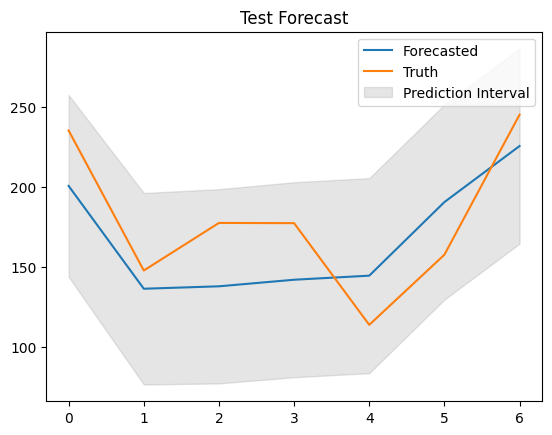

In [109]:
plt.plot(test_pred.to_numpy(),label="Forecasted")
plt.plot(test_truth.to_numpy(),label="Truth")
plt.fill_between(range(len(test_pred)), test_conf_int[:,0], test_conf_int[:,1], color='gray', alpha=0.2, label='Prediction Interval')
plt.legend()
plt.title("Test Forecast")
plt.show()

In [110]:
test_pred = test_pred.to_numpy()
test_truth = test_truth.to_numpy().flatten()
score = evaluate(test_pred,test_truth)
print(f"RMSE over 7 days : {score}")

RMSE over 7 days : 29.264782963438538


In [111]:
week_forecast = test_pred.sum()
week_truth = test_truth.sum()

print(f"Next week's forecast : {week_forecast}")
print(f"Next week's Truth : {week_truth}")
print(f"Next week's RMSE Error : {evaluate(np.array([week_truth]),np.array([week_forecast]))}")

Next week's forecast : 1177.5154542523494
Next week's Truth : 1254.6799999999998
Next week's RMSE Error : 77.16454574765044


In [156]:
score_dict[f"SARIMA{(5,1,1)}{(2,0,2,7)}"] = evaluate(np.array([week_truth]),np.array([week_forecast]))
score_dict

In [115]:
from pmdarima.arima import ARIMA
final_model = ARIMA(order=(5,1,1),seasonal_order=(2,0,2,7))

# Refit the model
final_model.fit(s)
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  726
Model:             SARIMAX(5, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -3502.127
Date:                                Sun, 17 Mar 2024   AIC                           7028.255
Time:                                        22:07:53   BIC                           7083.289
Sample:                                             0   HQIC                          7049.494
                                                - 726                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.714e-05      0.002     -0.015      0.988      -0.004       0.003
ar.L1          0.3083      0.031     10.037      0.000       0.248       0.368
ar.L2          0.0663      0.042      1.581      0.114      -0.016       0.148
ar.L3          0.0150      0.041      0.368      0.713      -0.065       0.095
ar.L4         -0.0413      0.042     -0.975      0.330      -0.124       0.042
ar.L5          0.0021      0.037      0.057      0.955      -0.070       0.074
ma.L1         -0.9842      0.012    -84.144      0.000      -1.007      -0.961
ar.S.L7        0.0298      0.071      0.419      0.675      -0.110       0.169
ar.S.L14       0.9691      0.071     13.620      0.000       0.830       1.109
ma.S.L7        0.1790      0.069      2.589      0.010       0.044       0.315
ma.S.L14      -0.7828      0.053    -14.742      0.000      -0.887      -0.679
sigma2       908.9321     35.224     25.804      0.000     839.894     977.970
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               406.59
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.66   Skew:                             0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

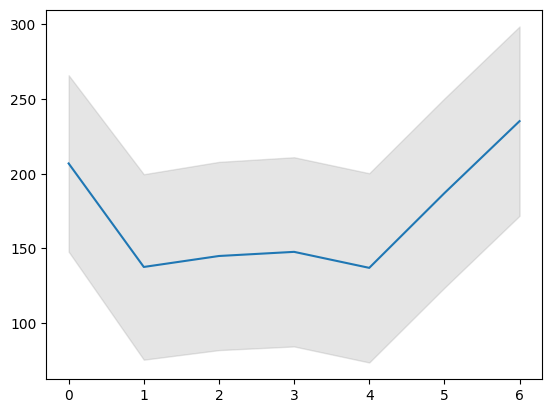

In [116]:
test_pred, test_conf_int = final_model.predict(7,return_conf_int=True,alpha=0.05)
test_pred = test_pred.to_numpy().flatten()
plt.plot(test_pred,label="Predict")
plt.fill_between(range(len(test_pred)), test_conf_int[:,0], test_conf_int[:,1], color='gray', alpha=0.2, label='Prediction Interval')
plt.show()

In [117]:
mean_week_forecast = test_pred.sum()
min_week_forecast = test_conf_int[:,0].sum()
max_week_forecast = test_conf_int[:,1].sum()

print(f"95% confident : Next week's forecast : {mean_week_forecast:.2f} ± {max_week_forecast-mean_week_forecast:.2f} dollars for {current_product_name}")

95% confident : Next week's forecast : 1196.34 ± 437.80 dollars for AJ BUTTERMILK PANCAKE MIX 32 OZ


### What's next
- Due to a limited time, it is possible to take explanatory variables into an account. See notebook
`[Time Series Analysis] Trial and Error Forecasting`. This can improve the accuracy of forecasting if they are actually a causal

- Here's examples

![](images/causal_and_time_series.png)

- How coupon may affect week dollar sales 
![](images/coupon_and_time_series.png)

- The difference between geography 1 and 2 dollar sales.  
![](images/geo1_and_geo2.png)

- Dollar Sale over stores.  
![](images/heatmap_geography.png)